In [106]:
#%% 
import collections
from numpy.lib.function_base import vectorize
import pandas as pd 
import numpy as np
import json
from scipy import sparse
import sklearn.metrics
import sklearn.neighbors
import sklearn.linear_model
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, plot_confusion_matrix

In [4]:
# load example data
data_train = fetch_20newsgroups(subset='train', shuffle=True)
# this is just a list of strings
data_test = fetch_20newsgroups(subset='test', shuffle=True)

In [5]:
# %%
def get_jsonl(path):

    with open(path) as json_file:
        json_list = list(json_file)

    data_list = []
    for json_str in json_list:
        data_list.append(json.loads(json_str))

    return pd.DataFrame(data_list)

In [6]:
# %%
# loading user  data 
USER_DATA = './resources/data/users.json'
df_user = pd.read_json(USER_DATA, orient="index")

# loading training data .jsonl
TRAINING_DATA = './resources/data/train.jsonl'
VAL_DATA = './resources/data/val.jsonl'

df_train, df_val = get_jsonl(TRAINING_DATA), get_jsonl(VAL_DATA)

In [127]:
df_train.head(2)

,id,category,title,rounds,date,pro_debater,con_debater,voters,winner
0,Atheism-is-more-probable-than-Theism./2/,Religion,Atheism is more probable than Theism.,"[[{'side': 'Pro', 'text': ' Thank you, Mu...",11/11/2012,Microsuck,Muted,"[truthseeker613, emj32, RationalMadman, Magic8...",Pro
1,The-Bible-is-unnecessary-to-the-Christian-fait...,Religion,The Bible is unnecessary to the Christian faith.,"[[{'side': 'Pro', 'text': ' The Bible is u...",6/10/2012,tapostol,Thaumaturgy,"[Ore_Ele, Cobo, KRFournier, TheOrator, CalvinA...",Con


In [178]:
# %%
df_train.columns
# df_train
# %%
# Explore the structure of rounds
one_round = df_train.loc[0, "rounds"] # this is a list of list of dictionary
two_sides = one_round[1] # this is a list consists of two sides speaking

import json
# json.dumps(one_round, indent=4)
# one_round


In [179]:
def get_texts(df):
    '''
    Return a list of statements in df without differentiating the side of the speaker
    '''

    texts = []
    for round in df.loc[:, 'rounds']:
        for sub_round in round:
            for speech in sub_round:
                texts.append(speech['text'])

    return texts

def get_text_by_side(df): 
    '''
    Return a list of documents where each document contains all text on one side in a 
    single debate
    
    text = [[Pro statement 1, Pro statement 2, ... Pro statement n],
            [Con statement 1, Con statement 2, ... Con statement m]]
            where n, m is the total number of statements from Pro and Con side across
            all debates

    size: [n x 2 x # statements in each debate]
    '''

    text = []
    for round in df.loc[:, 'rounds']:
        round_text = collections.defaultdict(list)

        for sub_round in round:
            for speech in sub_round: 
                round_text[speech['side']].append(speech['text'])

        for speech in round_text.values():
            text.append("".join(speech))

    return text

def get_ngram_feature(df, vectorizer: TfidfVectorizer): 
    '''
    Return the ngram features associated with a single debate

    For pro side, each document is defined as a string that contains all the statements 
    from the pro side in a single debate (across different subrounds). Con side is 
    similarly defined. 

    return [[Pro side n gram vector, Con side n gram vector for 1 debate],
            [Pro side n gram vector, Con side n gram vector for 2 debate],
            ...]

            size: [n, 2 x ngram count]
    
    Pro side and con side n gram vector are concatenated.
    '''

    pro_text, con_text = [], []

    for round in df.loc[:, 'rounds']: 
        round_text_list = collections.defaultdict(list)
        round_feature = []

        for sub_round in round:
            for speech in sub_round: 
                round_text_list[speech['side']].append(speech['text'])

        round_text = {}
        for side, speech in round_text_list.items():
            one_side_text = "".join(speech)
            round_text[side] = one_side_text
            
        pro_text.append(round_text['Pro'])
        con_text.append(round_text['Con'])

    pro_feature = vectorizer.transform(pro_text)
    con_feature = vectorizer.transform(con_text)
    print("pro , con shape are", pro_feature.shape, con_feature.shape)
    return sparse.hstack([pro_feature, con_feature])   

def get_debate_feature(df):
    '''
    Return the debate feature such as category, pro_debator user name, etc

    feature: [n, # of features] 
    '''
    feature_name = ['category']
    feature = []

    for name in feature_name: 
        # TODO: check for data type of the column. If non-numeric, then do this
        # otherwise, use the numerical data
        encoding, unique_feature_val = pd.factorize(df[name])
        feature.append(encoding)

    return np.reshape(np.array(feature), [-1, len(feature_name)])

    
def get_winner(df): 
    '''
    Cons gets mapped to 0 and pro gets mapped to 1
    '''
    return df.loc[:, "winner"].replace({"Con": 0, "Pro": 1})


In [171]:
print(debate_feature_train.shape)
print(debate_feture_val.shape)

(1592, 1)
(399, 1)


In [180]:
# Extracting texts from training and testing data
label_train = get_winner(df_train)
label_val = get_winner(df_val)

# Generate the corpus 
document_train = get_text_by_side(df_train)
document_test = get_text_by_side(df_val)

# Vectorization
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.9, stop_words='english', ngram_range=(1,3))
vectorizer.fit(document_train)

# Getting two sets of features - ngram and debate related features
ngram_feature_train = get_ngram_feature(df_train, vectorizer)
ngram_feature_val = get_ngram_feature(df_val, vectorizer)

debate_feature_train = get_debate_feature(df_train)
debate_feture_val = get_debate_feature(df_val)

# Combining two sets of features
X_train = sparse.hstack([debate_feature_train, ngram_feature_train])
X_val = sparse.hstack([debate_feture_val, ngram_feature_val])

y_train = np.array(label_train)
y_val = np.array(label_val)

pro , con shape are (1592, 2960880) (1592, 2960880)
pro , con shape are (399, 2960880) (399, 2960880)


In [186]:
print('Sanity check')
print(df_train.shape[0], 'number of observations in the training set')
print(X_train.shape, 'number of observation x the size of ngram vectors in the training set')
print(y_train.shape, 'number of labels in the training set')
print(df_val.shape[0], 'number of observations in the validation set')
print(X_val.shape, 'number of observation x the size of ngram vectors in the validation set')
print(y_val.shape, 'number of labels in the validation set')


Sanity check
1592 number of observations in the training set
(1592, 5921761) number of observation x the size of ngram vectors in the training set
(1592,) number of labels in the training set
399 number of observations in the validation set
(399, 5921761) number of observation x the size of ngram vectors in the validation set
(399,) number of labels in the validation set


In [187]:
# Building and training the model
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X_train, y_train)
# %%

LogisticRegression()

Logistic Regression report:
              precision    recall  f1-score   support

         Pro       0.59      0.99      0.74       211
         Con       0.93      0.23      0.37       188

    accuracy                           0.63       399
   macro avg       0.76      0.61      0.55       399
weighted avg       0.75      0.63      0.56       399

Accuracy score:  0.6290726817042607
Balanced accuracy score:  0.6290726817042607


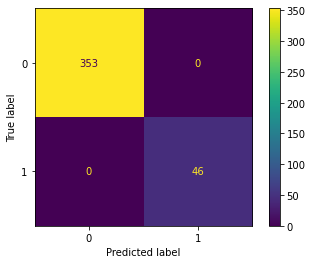

In [189]:
# Evaluating the model on the validation set
y_predicted = clf.predict(X_val)
print("Logistic Regression report:")
print(classification_report(y_val, y_predicted, target_names=['Pro', 'Con']))

print("Accuracy score: ",accuracy_score(y_val, y_predicted))
print("Balanced accuracy score: ",accuracy_score(y_val, y_predicted))

plot_confusion_matrix(clf, X_val, y_predicted)